## Read in necessary data

In [1]:
import cmdstanpy as csp

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# for the loss functions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

C:\Users\mirar\anaconda3\envs\stan\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_all = pd.read_csv("data_mags_5000.csv")

In [3]:
data_all.columns

Index(['template_id', 'median_z', 'mean_z', 'minchi2', 'mode_z', 'z_sigma68',
       'z_sigma', 'z_mc', 'concentration_i', 'concentration_cal_i',
       'asymmetry_i', 'clumpiness_i', 'gini_i', 'm20_i', 'mag_sersic_i',
       'mag_cal_i', 're_sersic_i', 're_cal_i', 'n_sersic_i', 'n_sersic_cal_i',
       'ellipticity_sersic_i', 'ellipticity_sersic_cal_i'],
      dtype='object')

Read in all relevant data columns

In [11]:
# template data
group_id = data_all["template_id"] + 1 # + 1 since python and stan use different indices

# galaxy properties
mag_sersic = data_all["mag_sersic_i"]
m20 = data_all['m20_i']

In [12]:
# easy way to change the data to run on ONLY CHANGE IT HERE
x_data = mag_sersic
y_data = m20

# change labels for plots and accessing from dataframes
# NOTE: string must be the same as a column from data_all in order to access the dataframe later
x_label = "mag_sersic_i"
y_label = "m20_i"

# name the folder in the repo to save plots in. folder must exist already
folder_name = "saved-plots/"

In [13]:
# other prior information needed for the model
N = data_all.shape[0] # total number of objects

num_templates = len(np.unique(group_id))

a1 = 1
b1 = 1
a2 = 1
b2 = 1
nu = 3
lambda_var = 1

In [14]:
# collect data as input for the model into a single variable
total_data = {'N': N,  
        'y_data': y_data,
        'x_data': x_data,
        'nu': nu,
        'lambda': lambda_var,}

no_data = {'N': N, 
        'J': num_templates,
        'm': np.max(group_id), 
        'y_data': y_data,
        'x_data': x_data,
        'group_id': group_id,
        'nu': nu,
        'lambda': lambda_var,}

hier_data = {'N': N, 
        'J': num_templates,
        'm': np.max(group_id), 
        'y_data': y_data,
        'x_data': x_data,
        'group_id': group_id,
        'a1': a1,
        'b1': b1,
        'a2': a2,
        'b2': b2,
        'nu': nu,
        'lambda': lambda_var,}

### Define some extra loss functions

In [15]:
# define additional loss function methods
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Run the three models for total pooling, no pooling, and partial pooling

In [16]:
total_model = csp.CmdStanModel(stan_file = 'total-pooling.stan')
total_sample = total_model.sample(data = total_data, seed = 1, chains = 1,
                      iter_sampling = 1000, iter_warmup = 1000,
                      show_progress = False, show_console = False)

17:39:11 - cmdstanpy - INFO - compiling stan file C:\Users\mirar\Desktop\github-repos\stat-775-final\pooling-analysis\total-pooling.stan to exe file C:\Users\mirar\Desktop\github-repos\stat-775-final\pooling-analysis\total-pooling.exe
17:40:34 - cmdstanpy - INFO - compiled model executable: C:\Users\mirar\Desktop\github-repos\stat-775-final\pooling-analysis\total-pooling.exe
17:40:35 - cmdstanpy - INFO - CmdStan start processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing
17:41:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'total-pooling.stan', line 19, column 4 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'total-pooling.stan', line 19, column 4 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'total-pooling.stan', line 19, column 4 to column 29)
	Excepti

In [25]:
none_model = csp.CmdStanModel(stan_file = 'no-pooling.stan')
none_sample = none_model.sample(data = no_data, seed = 1, chains = 1,
                      iter_sampling = 1000, iter_warmup = 1000,
                      show_progress = False, show_console = False)

18:36:48 - cmdstanpy - INFO - compiling stan file C:\Users\mirar\Desktop\github-repos\stat-775-final\pooling-analysis\no-pooling.stan to exe file C:\Users\mirar\Desktop\github-repos\stat-775-final\pooling-analysis\no-pooling.exe
18:37:26 - cmdstanpy - INFO - compiled model executable: C:\Users\mirar\Desktop\github-repos\stat-775-final\pooling-analysis\no-pooling.exe
18:37:26 - cmdstanpy - INFO - CmdStan start processing
18:37:26 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
hier_model = csp.CmdStanModel(stan_file = 'hierarchical-regression.stan')
hier_sample = hier_model.sample(data = hier_data, seed = 1, chains = 1,
                      iter_sampling = 1000, iter_warmup = 1000,
                      show_progress = False, show_console = False)

18:39:55 - cmdstanpy - INFO - compiling stan file C:\Users\mirar\Desktop\github-repos\stat-775-final\pooling-analysis\hierarchical-regression.stan to exe file C:\Users\mirar\Desktop\github-repos\stat-775-final\pooling-analysis\hierarchical-regression.exe
18:40:47 - cmdstanpy - INFO - compiled model executable: C:\Users\mirar\Desktop\github-repos\stat-775-final\pooling-analysis\hierarchical-regression.exe
18:40:48 - cmdstanpy - INFO - CmdStan start processing
18:40:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:28 - cmdstanpy - INFO - Chain [1] done processing


## Plotting by template type
Group raw data by template ID and assign a color.

Make a line collection of all alphas and betas from each template group. Add in alpha_bar and beta_bar for a global linear fit.

### Total pooling

In [53]:
alpha_group = np.mean(total_sample.stan_variable("alpha"))
beta_group = np.mean(total_sample.stan_variable("beta"))

In [54]:
xs = np.arange(np.min(x_data), np.max(x_data), np.max(x_data)/1000)
segs = [] # for collection of lines to plot

# append the global linear fit as a single line, with only good templates
global_seg = []
global_data = alpha_group + beta_group*xs
global_seg.append(((xs[0], global_data[0]), (xs[-1], global_data[-1])))

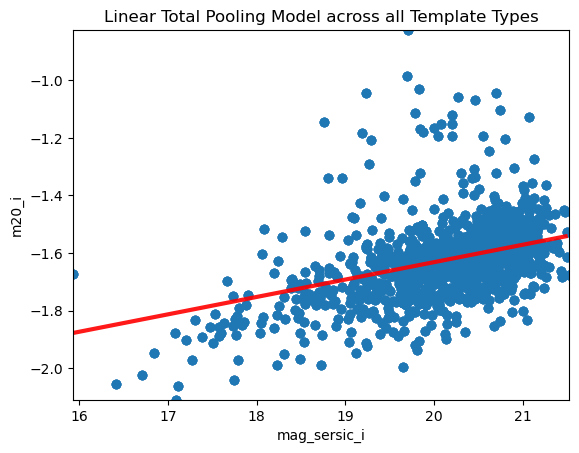

In [56]:
# plot all templates
fig, ax = plt.subplots()
ln_coll = matplotlib.collections.LineCollection(segs, array=color_map, alpha=0.8, linewidths=1.5)
global_ln_coll = matplotlib.collections.LineCollection(global_seg, color='red', alpha=0.9, linewidths=3)

ax.set_xlim(np.min(x_data), np.max(x_data))    
ax.set_ylim(np.min(y_data), np.max(y_data))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Linear Total Pooling Model across all Template Types")

ax.add_collection(ln_coll)
ax.add_collection(global_ln_coll)
ax.scatter(x_data, y_data, alpha=0.8)

fig.savefig(f"{folder_name}{y_label}_vs_{x_label}_all_total_pool.png", dpi=200)

### No pooling

In [34]:
alpha_group = np.array([np.mean(alpha_template) for alpha_template in none_sample.stan_variable("alpha").transpose()])
beta_group = np.array([np.mean(beta_template) for beta_template in none_sample.stan_variable("beta").transpose()])
color_map = np.arange(0, data_all["template_id"].max()+1)

In [35]:
xs = np.arange(np.min(x_data), np.max(x_data), np.max(x_data)/1000)
segs = [] # for collection of lines to plot
masked_segs = [] # generate list of linear fits that pass the loss functions
masked_alphas = [] # list of alphas that pass loss funtions
masked_betas = [] # list of betas that pass loss functions
masked_x_data = []
masked_y_data = []
masked_group_id = []

for template_id in range(len(alpha_group)):
    subset = data_all[data_all['template_id']==template_id]
    
    data = alpha_group[template_id] + beta_group[template_id]*xs
    
    segs.append(((xs[0], data[0]), (xs[-1], data[-1])))

    if len(subset) < 10:
        continue

    predicted = alpha_group[template_id] + beta_group[template_id] * subset[x_label]
    
    # calculate loss functions
    mse_val = mean_squared_error(subset[y_label], predicted)
    r2_val = r2_score(subset[y_label], predicted)

    if (mse_val < 0.7) and (r2_val > 0.25):
        masked_segs.append(((xs[0], data[0]), (xs[-1], data[-1])))
        masked_alphas.append(alpha_group[template_id])
        masked_betas.append(beta_group[template_id])
        masked_x_data.extend(subset[x_label])
        masked_y_data.extend(subset[y_label])
        masked_group_id.extend(np.full(len(subset[x_label]), template_id))

# append the global linear fit as a single line, with only good templates
masked_global_seg = []
masked_global_data = np.mean(masked_alphas) + np.mean(masked_betas)*xs
masked_global_seg.append(((xs[0], masked_global_data[0]), (xs[-1], masked_global_data[-1])))

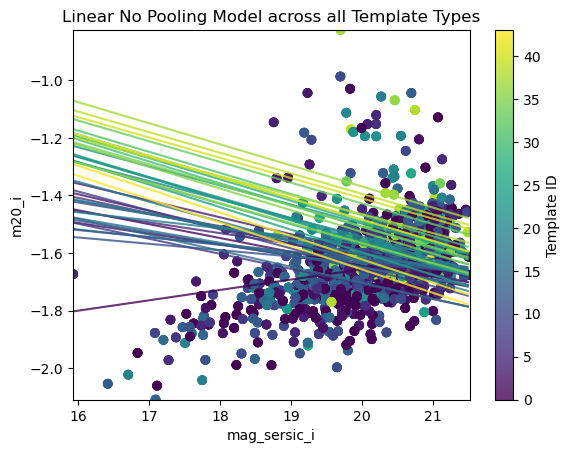

In [36]:
# plot all templates
fig, ax = plt.subplots()
ln_coll = matplotlib.collections.LineCollection(segs, array=color_map, alpha=0.8, linewidths=1.5)
global_ln_coll = matplotlib.collections.LineCollection(global_seg, color='red', alpha=0.9, linewidths=3)

ax.set_xlim(np.min(x_data), np.max(x_data))    
ax.set_ylim(np.min(y_data), np.max(y_data))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Linear No Pooling Model across all Template Types")

ax.add_collection(ln_coll)
ax.add_collection(global_ln_coll)
ax.scatter(x_data, y_data, c=group_id, alpha=0.8)

template_color = fig.colorbar(ln_coll)
template_color.set_label('Template ID')
fig.savefig(f"{folder_name}{y_label}_vs_{x_label}_all_no_pool.png", dpi=200)

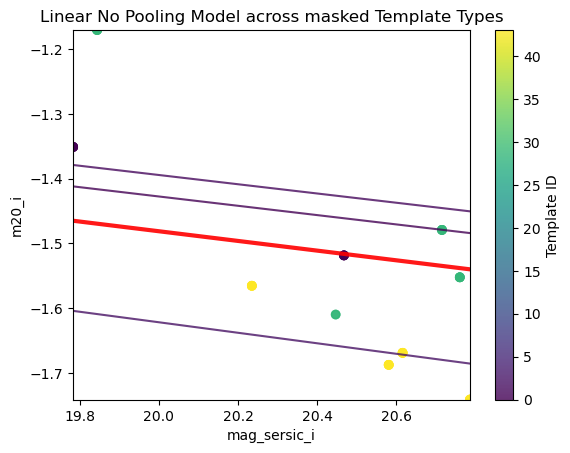

In [37]:
# only plot templates that pass the loss functions
fig, ax = plt.subplots()
ln_coll = matplotlib.collections.LineCollection(masked_segs, array=color_map, alpha=0.8, linewidths=1.5)
global_ln_coll = matplotlib.collections.LineCollection(masked_global_seg, color='red', alpha=0.9, linewidths=3)

ax.set_xlim(np.min(masked_x_data), np.max(masked_x_data))    
ax.set_ylim(np.min(masked_y_data), np.max(masked_y_data))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Linear No Pooling Model across masked Template Types")

ax.add_collection(ln_coll)
ax.add_collection(global_ln_coll)
ax.scatter(masked_x_data, masked_y_data, c=masked_group_id, alpha=0.8)

template_color = fig.colorbar(ln_coll)
template_color.set_label('Template ID')
fig.savefig(f"{folder_name}{y_label}_vs_{x_label}_mask_no_pool.png", dpi=200)

### Partial Pooling

In [38]:
alpha_group = np.array([np.mean(alpha_template) for alpha_template in hier_sample.stan_variable("alpha").transpose()])
beta_group = np.array([np.mean(beta_template) for beta_template in hier_sample.stan_variable("beta").transpose()])
color_map = np.arange(0, data_all["template_id"].max()+1)

In [39]:
# get the global slope and intercept
alpha_bar = np.mean(hier_sample.stan_variable('alpha_bar'))
beta_bar = np.mean(hier_sample.stan_variable('beta_bar'))
print(alpha_bar, beta_bar)

-2.62530433 0.07622404097


In [40]:
xs = np.arange(np.min(x_data), np.max(x_data), np.max(x_data)/1000)
segs = [] # for collection of lines to plot
masked_segs = [] # generate list of linear fits that pass the loss functions
masked_alphas = [] # list of alphas that pass loss funtions
masked_betas = [] # list of betas that pass loss functions
masked_x_data = []
masked_y_data = []
masked_group_id = []

for template_id in range(len(alpha_group)):
    subset = data_all[data_all['template_id']==template_id]
    
    data = alpha_group[template_id] + beta_group[template_id]*xs
    
    segs.append(((xs[0], data[0]), (xs[-1], data[-1])))

    if len(subset) < 10:
        continue

    predicted = alpha_group[template_id] + beta_group[template_id] * subset[x_label]
    
    # calculate loss functions
    mse_val = mean_squared_error(subset[y_label], predicted)
    r2_val = r2_score(subset[y_label], predicted)

    if (mse_val < 0.7) and (r2_val > 0.25):
        masked_segs.append(((xs[0], data[0]), (xs[-1], data[-1])))
        masked_alphas.append(alpha_group[template_id])
        masked_betas.append(beta_group[template_id])
        masked_x_data.extend(subset[x_label])
        masked_y_data.extend(subset[y_label])
        masked_group_id.extend(np.full(len(subset[x_label]), template_id))

# append the global linear fit as a single line, with all templates
global_seg = []
global_data = alpha_bar + beta_bar*xs
global_seg.append(((xs[0], global_data[0]), (xs[-1], global_data[-1])))

# append the global linear fit as a single line, with only good templates
masked_global_seg = []
masked_global_data = np.mean(masked_alphas) + np.mean(masked_betas)*xs
masked_global_seg.append(((xs[0], masked_global_data[0]), (xs[-1], masked_global_data[-1])))

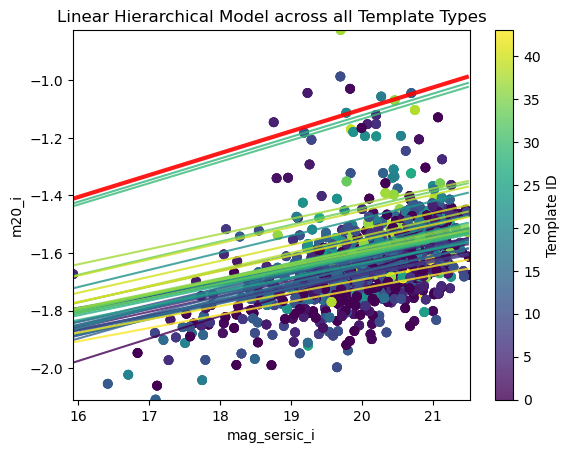

In [41]:
# plot all templates
fig, ax = plt.subplots()
ln_coll = matplotlib.collections.LineCollection(segs, array=color_map, alpha=0.8, linewidths=1.5)
global_ln_coll = matplotlib.collections.LineCollection(global_seg, color='red', alpha=0.9, linewidths=3)

ax.set_xlim(np.min(x_data), np.max(x_data))    
ax.set_ylim(np.min(y_data), np.max(y_data))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Linear Hierarchical Model across all Template Types")

ax.add_collection(ln_coll)
ax.add_collection(global_ln_coll)
ax.scatter(x_data, y_data, c=group_id, alpha=0.8)

template_color = fig.colorbar(ln_coll)
template_color.set_label('Template ID')
fig.savefig(f"{folder_name}{y_label}_vs_{x_label}_all_partial_pool.png", dpi=200)

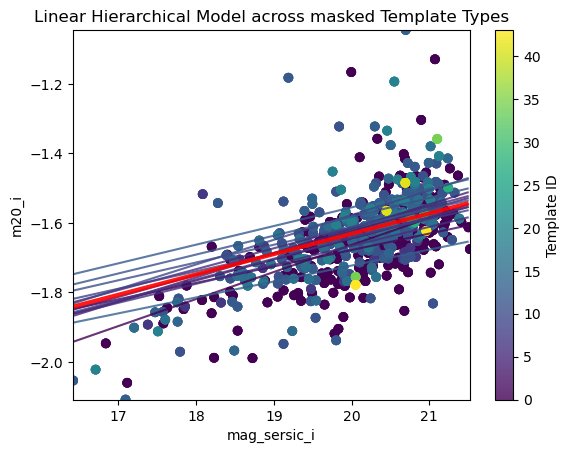

In [42]:
# only plot templates that pass the loss functions
fig, ax = plt.subplots()
ln_coll = matplotlib.collections.LineCollection(masked_segs, array=color_map, alpha=0.8, linewidths=1.5)
global_ln_coll = matplotlib.collections.LineCollection(masked_global_seg, color='red', alpha=0.9, linewidths=3)

ax.set_xlim(np.min(masked_x_data), np.max(masked_x_data))    
ax.set_ylim(np.min(masked_y_data), np.max(masked_y_data))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Linear Hierarchical Model across masked Template Types")

ax.add_collection(ln_coll)
ax.add_collection(global_ln_coll)
ax.scatter(masked_x_data, masked_y_data, c=masked_group_id, alpha=0.8)

template_color = fig.colorbar(ln_coll)
template_color.set_label('Template ID')
fig.savefig(f"{folder_name}{y_label}_vs_{x_label}_mask_partial_pool.png", dpi=200)